<a href="https://colab.research.google.com/github/Aspire-Mayank/EVA/blob/master/Phase2/Session10/ENDGAME/SelfDrivingCarT3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation Approch

>Following is the strategy to train
  * Load the sand image and move the coordinates (Vector) in env.Step() for simulating car movement.
  * State is captured by cropping a portion of sand image from car's position. And then rotating it in the direction of the car in such a way that car's orientation is horizontal i.e 0 degrees from x-axis. This state is passed to Actor network
  * Action is 1 dimensional, with its value being amount of angle the car should rotate

* Following above approch, as we can't run Kivy on Colab and because we don't have GPUs on our desktop, 

This is Complete course for main understanding from scratch [awesome Deep Reinforcement Learning 2.0 Course on Udemy](https://www.udemy.com/course/deep-reinforcement-learning/).

## Importing the libraries
* Although Kivy is not used in Colab, we are installing it to use its `Vector` module for simulating Kivy environment

In [1]:
!pip install kivy

In [0]:
%matplotlib notebook

import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import matplotlib.patches as patches
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque
from PIL import Image as PILImage

# Define Replay Buffer Memory
* This is a fixed size array storing multiple experiences.
* An experience (aka transition) is defined by the following:
  * s: current state in which the agent is
  * a: action the agent takes to go to next state
  * s': new state agent reaches after taking an action (a)
  * r: reward an agent receive for going from state (s) to state (s') by taking action (a)
* Initially, agent plays with the environment randomly and fills in replay memory.
* Then during training, a batch of experiences is sampled randomly to train the agent.
* Also this memory is simultaneously filled as and when agent explores the environment.
* If memory is full, then first entry is removed and new entry is added.



In [0]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    ind = np.random.randint(0, len(self.storage), size=batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
    for i in ind: 
      state, next_state, action, reward, done = self.storage[i]
      batch_states.append(np.array(state, copy=False))
      batch_next_states.append(np.array(next_state.cpu(), copy=False))
      batch_actions.append(np.array(action, copy=False))
      batch_rewards.append(np.array(reward, copy=False))
      batch_dones.append(np.array(done, copy=False))
    return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

* Fetch device information. This is very useful to speed up network training/inference by using GPU when available. If GPU is not available then, CPU is used

In [0]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Network Architecture
* We build one neural network for the Actor model and one neural network for the Actor target
* MobileNet were used for this implementation as very simple CNN network required and also the network should have good speed
* Below also hosts common functions used to build Actor and Critic networks
* conv_s: does simple conv2d with kernel size 3x3 and padding 1
* conv_dw: does depthwise convolution with padding 1
* state_model: common state network used for both Actor and Critic networks

In [0]:
def conv_s(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
    )

def state_model():
    return nn.Sequential(
            # CHW: 1, 32, 32
            conv_s(  1,  32, 1), # 32, 32, 32
            conv_dw( 32,  32, 1), # 32, 32, 32
            conv_dw( 32,  16, 2), # 32, 16, 16
            conv_dw( 16,  16, 1), # 16, 16, 16
            conv_dw( 16,  16, 2), # 16,  8,  8
            nn.AvgPool2d(8),
        )

# Creating the architecture of the Neural Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.model = state_model()
        self.fc1 = nn.Linear(16, 100)
        self.fc2 = nn.Linear(100, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 16)
        x = self.fc2(self.fc1(x))
        x = self.max_action * torch.tanh(x)
        return x

### Was trying Basic Network for Actor and Critic but geting error while Transformation.

In [0]:
# class Actor(nn.Module):
#     def __init__(self, state_dim, action_dim, max_action):
#         super(Actor, self).__init__()
#         # Input Block
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=state_dim, out_channels=8, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.Dropout(0.1))  # output_size = 32

#         # CONVOLUTION BLOCK 1
#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output_size = 32

#         # TRANSITION BLOCK 1
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 16

#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 16

#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 16

#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 8

#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 8

#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 8

#         self.convblock9 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, bias=False))  # output 4

#         self.GAP = nn.AvgPool2d(kernel_size=1, stride=1)
#         self.max_action = max_action
#         self.action_dim = action_dim

#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.convblock3(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)
#         x = self.convblock7(x)
#         x = self.convblock8(x)
#         x = self.convblock9(x)
#         x = self.GAP(x)
#         x = x.view(-1, 16)
#         x = self.max_action * torch.tanh(nn.Linear(x, self.action_dim))
#         return x

# class Critic(nn.Module):
#     def __init__(self, state_dim, action_dim):
#         super(Critic, self).__init__()
#         # Define first Critic neural network
#         # Action_dim angle after GAP as put on same dimension
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=state_dim, out_channels=8, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.Dropout(0.1))  # output_size = 32

#         # CONVOLUTION BLOCK 1
#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output_size = 32

#         # TRANSITION BLOCK 1
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 16

#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 16

#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 16

#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 8

#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 8

#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 8

#         self.convblock9 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, bias=False))  # output 4

#         self.GAP1 = nn.AvgPool2d(kernel_size=1, stride=1)
#         self.Linear1 = nn.Linear(17, 1)

#         # Define the second Critic neural network
#         self.convblock11 = nn.Sequential(
#             nn.Conv2d(in_channels=state_dim, out_channels=8, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.Dropout(0.1))  # output_size = 32

#         # CONVOLUTION BLOCK 1
#         self.convblock22 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output_size = 30

#         self.convblock33 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 16

#         self.convblock44 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 16

#         self.convblock55 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 16

#         self.convblock66 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 8

#         self.convblock77 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 8

#         self.convblock88 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.1))  # output 8

#         # OUTPUT BLOCK
#         self.convblock99 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, bias=False))  # output 4

#         self.GAP2 = nn.AvgPool2d(kernel_size=1, stride=1)
#         self.Linear2 = nn.Linear(17, 1)

#     def forward(self, x, u):
#         # Forward-Propogation on the first Critic Neural network
#         x1 = self.convblock1(x)
#         x1 = self.convblock2(x1)
#         x1 = self.convblock3(x1)
#         x1 = self.convblock4(x1)
#         x1 = self.convblock5(x1)
#         x1 = self.convblock6(x1)
#         x1 = self.convblock7(x1)
#         x1 = self.convblock8(x1)
#         x1 = self.convblock9(x1)
#         x1 = self.GAP1(x1)
#         x1 = x1.view(-1, 16)
#         x1 = torch.cat([x1, u], 1)
#         x1 = self.Linear1(x1, 1)

#         # Forward-Propagation on the second Critic Neural Network
#         x2 = self.convblock11(x)
#         x2 = self.convblock22(x2)
#         x2 = self.convblock33(x2)
#         x2 = self.convblock44(x2)
#         x2 = self.convblock55(x2)
#         x2 = self.convblock66(x2)
#         x2 = self.convblock77(x2)
#         x2 = self.convblock88(x2)
#         x2 = self.convblock99(x2)
#         x2 = self.GAP2(x2)
#         x2 = x2.view(-1, 16)
#         x2 = torch.cat([x2, u], 1)
#         x2 = self.Linear2(x2, 1)
#         return x1, x2

#     def Q1(self, x, u):
#         x1 = self.convblock1(x)
#         x1 = self.convblock2(x1)
#         x1 = self.convblock3(x1)
#         x1 = self.convblock4(x1)
#         x1 = self.convblock5(x1)
#         x1 = self.convblock6(x1)
#         x1 = self.convblock7(x1)
#         x1 = self.convblock8(x1)
#         x1 = self.convblock9(x1)
#         x1 = self.GAP1(x1)
#         x1 = x1.view(-1, 16)
#         x1 = torch.cat([x1, u], 1)
#         x1 = self.Linear1(x1, 1)
#         return x1

In [7]:
from torchsummary import summary

model = Actor((1, 32,32),1,10).to(device)
summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             288
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           1,024
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 16, 16]             288
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             ReLU-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]             512
      BatchNorm2d-14           [-1, 16,

* We build two neural networks for the two Critic models and two neural networks for the two Critic targets
* Uses common functions defined above
* State and Actor inputs are concatenated before FC (fully connected) layers

In [0]:
# Creating the architecture of the Neural Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Defining the first Critic neural network
        self.c1_model = state_model()
        self.c1_fc1 = nn.Linear(16 + action_dim, 100)
        self.c1_fc2 = nn.Linear(100, 1)

        # Defining the second Critic neural network
        self.c2_model = state_model()
        self.c2_fc1 = nn.Linear(16 + action_dim, 100)
        self.c2_fc2 = nn.Linear(100, 1)

    def forward(self, x, u):
      # xu = torch.cat([x, u], 2)
      # Forwad-Propagation on the first Critic Neural Network
      x1 = self.c1_model(x)
      x1 = x1.view(-1, 16)
      x1 = torch.cat([x1, u], 1)
      x1 = self.c1_fc2(self.c1_fc1(x1))

      # Forward-Propagation on the second Critic Neural Network
      x2 = self.c2_model(x)
      x2 = x2.view(-1, 16)
      x2 = torch.cat([x2, u], 1)
      x2 = self.c2_fc2(self.c2_fc1(x2))
      return x1, x2

    def Q1(self, x, u):
      x1 = self.c1_model(x)
      x1 = x1.view(-1, 16)
      x1 = torch.cat([x1, u], 1)
      x1 = self.c1_fc2(self.c1_fc1(x1))
      return x1

* Below torch summary fails to calculate parameters
* This is a known torchsummary issue

In [9]:
model = Critic(2,1).to(device)
summary(model, input_size=[(1, 32, 32), (1,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             288
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           1,024
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 16, 16]             288
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             ReLU-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]             512
      BatchNorm2d-14           [-1, 16,

TypeError: ignored

## Define T3D for Training Process whole process

In [0]:
# Building the whole Training Process into a class
class T3D(object):
  
  def __init__(self, state_dim, action_dim, max_action):
    self.max_action = torch.Tensor(max_action).to(device)
    self.actor = Actor(state_dim, action_dim, self.max_action).to(device)
    self.actor_target = Actor(state_dim, action_dim, self.max_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    
  def select_action(self, state):
    state = state.unsqueeze(0).to(device)
    return self.actor(state).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    for it in range(iterations):
      # We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)
      
      # From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state)#.squeeze(1)

      # We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action = (next_action + noise).clamp(-self.max_action[0], self.max_action[0])

      # The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      
      # We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)
      
      # We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

# Set the Hyperparameters

In [0]:
env_name = "SelfDrivingCarEnv" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 2e4 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e5 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.1 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = 0.2 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated

## We create a file name for the two saved models: the Actor and Critic models

In [19]:
file_name = "%s_%s_%s" % ("T3D", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

---------------------------------------
Settings: T3D_SelfDrivingCarEnv_0
---------------------------------------


## We create a folder inside which will be saved the trained models

In [0]:
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

# Download Image

In [26]:
!wget -O MASK1.png https://drive.google.com/uc\?export\=view\&id\=1eHsgsEdvdUMZjSR5XUhA2kFgdPK3qSN3

--2020-05-07 13:17:02--  https://drive.google.com/uc?export=view&id=1eHsgsEdvdUMZjSR5XUhA2kFgdPK3qSN3
Resolving drive.google.com (drive.google.com)... 172.217.5.206, 2607:f8b0:4007:803::200e
Connecting to drive.google.com (drive.google.com)|172.217.5.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ol6e3psahjjs33d6jts81e432cu1lc1s/1588857375000/09305796575597883680/*/1eHsgsEdvdUMZjSR5XUhA2kFgdPK3qSN3?e=view [following]
--2020-05-07 13:17:02--  https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ol6e3psahjjs33d6jts81e432cu1lc1s/1588857375000/09305796575597883680/*/1eHsgsEdvdUMZjSR5XUhA2kFgdPK3qSN3?e=view
Resolving doc-0c-60-docs.googleusercontent.com (doc-0c-60-docs.googleusercontent.com)... 216.58.217.193, 2607:f8b0:4007:808::2001
Connecting to doc-0c-60-docs.googleusercontent.com (doc-0c-60-docs.googleusercont

# Define helper functions for Cropping Image
* Below are helper functions to crop the image and perform rotation on it


In [0]:
%matplotlib inline
from PIL import Image, ImageOps
import matplotlib.markers as mmarkers

def rotate_img(img, angle):
  im1 = img.convert('RGBA')
  rot = im1.rotate(angle)
  # a white image same size as rotated image
  fff = Image.new('RGBA', rot.size, (255,)*4)
  # create a composite image using the alpha layer of rot as a mask
  return Image.composite(rot, fff, rot).convert('L')

def show_img(ax, img, title=""):
  np_img = np.asarray(img)/255
  np_img = np_img.astype(int)
  ax.imshow(np_img, cmap='gray', vmin=0, vmax=1)
  if title != "":
    ax.set_title(title)

def crop(img, x, y , angle = 0, crop_size = 100, scale_size = 32):
    img = np.asarray(img)
    def pad_with(vector, pad_width, iaxis, kwargs):
            pad_value = kwargs.get('padder', 10)
            vector[:pad_width[0]] = pad_value
            vector[-pad_width[1]:] = pad_value    
    img = np.pad(img, crop_size // 2, pad_with, padder=255.)
    img_x, img_y = img.shape
    
    x += crop_size // 2
    y += crop_size // 2
    center_x = x + 10
    center_y = y + 5    

    cropped_image = img[center_x - crop_size//2:center_x + crop_size//2,center_y - crop_size//2:center_y + crop_size//2]

    res = cv2.resize(cropped_image, dsize=(scale_size,scale_size), interpolation=cv2.INTER_CUBIC)
    res = np.expand_dims(res, axis=0)
    res = torch.from_numpy(res)
    return res

def center_crop_img(img, x, y, crop_size):
  max_x, max_y = img.size
  pad_left, pad_right, pad_bottom, pad_top = 0, 0, 0, 0
  start_x = x - int(crop_size/2)
  start_y = y - int(crop_size/2)
  end_x = x + int(crop_size/2)
  end_y = y + int(crop_size/2)
  if start_x < 0:
      pad_left = -start_x
      start_x = 0
  if end_x >= max_x:
      pad_right = end_x - max_x
  if start_y < 0:
      pad_top = -start_y
      start_y = 0
  if end_y >= max_y:
      pad_bottom = end_y - max_y
  padding = (int(pad_left), int(pad_top), int(pad_right), int(pad_bottom))
  new_img = ImageOps.expand(img, padding, fill=255)
  crop_img = new_img.crop((start_x, start_y, start_x+crop_size, start_y+crop_size))

  return crop_img

## Environment creation for Simulation 
* We simulate Kivy environment here. As Kivy doesn't do much apart from Graphics
* We maintain x,y position and car's angle. This is rotated based on action
* Action here is one-dimensional, which is the amount of degrees the car should rotate
* If x,y position is on sand, we set a small velocity, else a slightly high velocity
* Our state here corresponds to the cropped portion of current postion as center. This image is rotated to be in the direction of car. This was our network understands car's orientation
* Cropping here is done differently. If we directly crop and rotate the image, we may loose information from the edges. Hence we do the following:
  * Crop a larger portion of image
  * Rotate it to make the cropped image in the direction of car's orientation
  * Then crop it to required size
* `reset` function picks a random coordinates on road and a random angle and returns state

In [0]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib.markers as mmarkers

from PIL import Image as PILImage
from kivy.vector import Vector
from collections import Counter

class CarEnv(object):
    def __init__(self):
        self.filename = "MASK1.png"
        img = PILImage.open(self.filename).convert('L')
        self.sand = np.asarray(img)/255
        self.sand = self.sand.astype(int)
        self.max_y, self.max_x = self.sand.shape
        self.pos = Vector(int(self.max_x/2), int(self.max_y/2))
        self.angle = Vector(0,10).angle(self.pos)
        self.velocity = Vector(6, 0)
        self.wall_padding = 20
        self.rel_pos = Vector(0,0)
        self.max_angle = 10
        self.max_action = [self.max_angle]
        self.crop_size = 100
        self.goal_iter = 0
        self.goals = [Vector(1650, 130), Vector(160, 390)]
        self.last_distance = 0
        self.state_dim = (32, 32)
        self.action_dim = (1,)
        self._max_episode_steps = 4000
        # track rewards distribution
        self.rewards_distribution = Counter()
      
    def seed(self, seed):
        pass
    
    def reset(self):
        self.angle = np.random.randint(low=0, high=360)
        onsand = True
        while onsand:
          self.pos.x = np.random.randint(low=self.wall_padding, high=self.max_x-self.wall_padding)
          self.pos.y = np.random.randint(low=self.wall_padding, high=self.max_y-self.wall_padding)
          if self.sand[int(self.pos.y),int(self.pos.x)] <= 0:
              onsand = False
        self.velocity = Vector(2, 0).rotate(self.angle)
        return self.get_state()
    
    def random_action(self):
        rotation = np.random.randint(low=-self.max_angle, high=self.max_angle)
        return (rotation,)
    
    def step(self, action):
        rotation = action[0]
        self.angle += rotation
        self.pos = Vector(*self.velocity) + self.pos
        self.pos.x = int(self.pos.x)
        self.pos.y = int(self.pos.y)
        reward = 0
        done = False
        current_goal = self.goals[self.goal_iter]

        distance = self.pos.distance(current_goal)
        if self.sand[int(self.pos.y),int(self.pos.x)] > 0:
            self.velocity = Vector(0.5, 0).rotate(self.angle)
            reward = -1
            tag = "sand (-1)"
        else: # otherwise
            self.velocity = Vector(2, 0).rotate(self.angle)
            reward = -0.1
            tag = "road (-0.1)"
            
            if distance < self.last_distance:
              reward = 1
              tag = "road (+1)"

        if self.pos.x < self.wall_padding:
            self.pos.x = self.wall_padding
            reward = -5
            tag = "wall (-5)"
            done = True
        if self.pos.x > self.max_x - self.wall_padding:
            self.pos.x = self.max_x - self.wall_padding
            reward = -5
            tag = "wall (-5)"
            done = True
        if self.pos.y < self.wall_padding:
            self.pos.y = self.wall_padding
            reward = -5
            tag = "wall (-5)"
            done = True
        if self.pos.y > self.max_y - self.wall_padding:
            self.pos.y = self.max_y - self.wall_padding
            reward = -5
            tag = "wall (-5)"
            done = True

        if distance < 25:
            self.goal_iter = (self.goal_iter + 1) % len(self.goals)
            goal = self.goals[self.goal_iter]
            reward = 10
            tag = "goal (+10)"
            done = True

        self.last_distance = distance
        self.rewards_distribution[tag] += 1
        return self.get_state(), reward, done
    
    def render(self):
        # Create figure and axes
        fig, ax = plt.subplots(1, 5, figsize=(30, 6))

        # Display the image
        ax[0].imshow(self.sand, cmap='gray', vmin=0, vmax=1)
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (self.pos.x - int(self.crop_size/2), self.pos.y - int(self.crop_size/2)),
            self.crop_size, self.crop_size,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        # Add the patch to the Axes
        ax[0].add_patch(rect)
        ax[0].set_title("x=%d,y=%d,angle=%d" % (self.pos.x, self.pos.y, self.angle))
        
        marker = mmarkers.MarkerStyle(marker="$ \\rightarrow$")
        marker._transform = marker.get_transform().rotate_deg(self.angle)
        ax[0].scatter(self.pos.x, self.pos.y, s=50, c='red', marker=marker)
        self.get_state(ax).cpu().numpy()
        plt.show()
        
    def get_state(self, ax=None):
        resize = T.Compose([T.ToPILImage(),
                            T.Resize(self.state_dim[0], interpolation=Image.CUBIC),
                            T.ToTensor()])
        
        img = Image.open(self.filename).convert('L')

        # If we directly crop and rotate the image, we may loose information
        # from the edges. Hence we do the following:
        #   * Crop a larger portion of image
        #   * Rotate it to make the cropped image in the direction
        #     of car's orientation
        #   * Then crop it to required size
        crop_img = center_crop_img(img, self.pos.x, self.pos.y, self.crop_size*3)
        if ax is not None:
          show_img(ax[1], crop_img, "large crop")

        r_img = rotate_img(crop_img, -self.angle)
        if ax is not None:
          show_img(ax[2], r_img, "rotated crop")

        r_img_x, r_img_y = r_img.size
        crop_img = center_crop_img(r_img, int(r_img_x/2), int(r_img_y/2), self.crop_size)
        if ax is not None:
          show_img(ax[3], crop_img, "final crop")

        np_img = np.asarray(crop_img)/255
        np_img = np_img.astype(int)
        screen = np.ascontiguousarray(np_img, dtype=np.float32) 
        screen = torch.from_numpy(screen)
        screen = resize(screen)
        if ax is not None:
            np_img = screen.squeeze(0).numpy()
            np_img = np_img.astype(int)
            ax[4].imshow(np_img, cmap='gray', vmin=0, vmax=1)
            marker = mmarkers.MarkerStyle(marker="$ \\rightarrow$")
            ax[4].scatter(self.state_dim[0]/2, self.state_dim[1]/2, s=100, c='red', marker=marker)
            ax[4].set_title("final resized img")
        return screen.to(device)

# Visualizing Environment
* Here we crop large portion of image from postion x,y. Then rotate it and then crop it again to required size. Then resize it to required final size
* It is visualized below

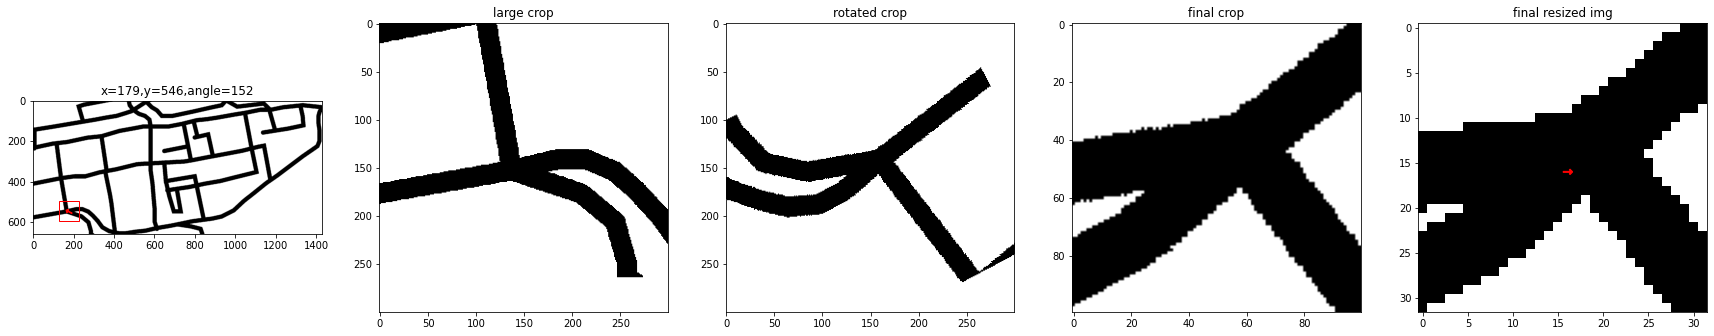

In [29]:
env = CarEnv()
env.reset()
env.render()

# Small animation to understand env step

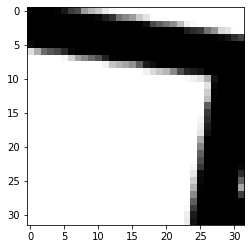

In [30]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep

plt.figure()
env = CarEnv()
env.reset()
for i in range(20):
    img = env.get_state().cpu().squeeze(0).numpy()
    plt.imshow(img, cmap='gray', animated=True, vmin=0, vmax=1)
    plt.show()
    sleep(0.2)
    clear_output(wait=True)
    vel = np.random.randint(low=0.5, high=5)
    angle = np.random.randint(low=-10, high=+10)
    env.step((angle,))


## Set seeds and get the necessary information on the states and actions in the chosen environment

In [0]:
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.state_dim
action_dim = env.action_dim[0]
max_action = env.max_action

## Create the policy network
* This sets up all the networks: Actor, Actor-Target, Critic1, Critic1-Target, Critic2, Critic2-Target

In [0]:
policy = T3D(state_dim, action_dim, max_action)

## Initialize the Experience ReplayBuffer memory

In [0]:
replay_buffer = ReplayBuffer()

## Verify policy network before training

In [34]:
obs = env.reset()
action = policy.select_action(obs)
new_obs, reward, done,  = env.step(action)
print(obs.shape, new_obs.shape, action, reward, done)

torch.Size([1, 32, 32]) torch.Size([1, 32, 32]) [1.2357162] -0.1 False


## We make a function that evaluates the policy by calculating its average reward over 10 episodes

In [0]:
def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    episode_timesteps = 0
    while not done:
      action = policy.select_action(obs)
      obs, reward, done = env.step(action)
      episode_timesteps += 1
      avg_reward += reward
      if episode_timesteps + 1 == env._max_episode_steps:
        done = True

  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

## Define a list where all the evaluation results over 10 episodes are stored

In [0]:
evaluations = []

## Initialize the variables

In [0]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()

## Training process
* As part of training, we show following output:
  * Total number of timesteps taken, Episode number, Length of current episod, Total reward accumulated during this episode and Time taken to finish this episode
```
Total Timesteps: 561 Episode Num: 1 Episode Len: 561 Reward: -449.7 Time Taken: 8.64677596092 secs
```
  * Distribution of rewards. This is not from replay memory, but from the actual steps taken during this run of episode. It shows how much and from where rewards were allocated. Like:
    * `road (+1)` means it got +1 reward for being on road and for going towards final goal
    * `road (-0.1)` means it got -0.1 reward for being on road but not going towards final goal (this is living penalty)
    * `sand (-1)` means it got -1 reward for being on sand
    * `wall (-5)` means it got -5 reward for hitting the wall
    * Note: we assign a reward of -10 if we hit max episode steps
    ```
('Rewards Distribution: ', [('road (+1)', 33), ('road (-0.1)', 76), ('sand (-1)', 472), ('wall (-5)', 1)])
    ```
  * Amound of time taken by `policy.train` to finish 
```
Training took 24.9262328148 secs
```
  * Path. Set of coordinates noted at every 100 steps, to verify that the network starts from a random point and covers lot of new points, rather than being stuck in a loop 
```
('Path', [[783, 379], [784, 377], [757, 255], [647, 167], [598, 167], [545, 192], [561, 86]])
```


In [0]:
import time

max_timesteps = 500000
start_time = time.time()
path = []
# We start the main loop over 500,000 timesteps
while total_timesteps < max_timesteps:
  
  # If the episode is done
  if done:

    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      print("Total Timesteps: {} Episode Num: {} Episode Len: {} Reward: {} Time Taken: {} secs".format(
              total_timesteps, episode_num, episode_timesteps,
              episode_reward, time.time() - start_time))
      print("Rewards Distribution: ", sorted(env.rewards_distribution.items()))
      env.rewards_distribution = Counter()
      start_time = time.time()
      policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)
      print("Training took {} secs".format(time.time() - start_time))
      print("Path", path)
      print("")
      start_time = time.time()

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy))
      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)
      start_time = time.time()
    
    # When the training step is done, we reset the state of the environment
    obs = env.reset()
    path = [env.pos]
    
    # Set the Done to False
    done = False
    
    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
  
  # Before 10000 timesteps, we play random actions
  if total_timesteps < start_timesteps:
    action = env.random_action()
  else: # After 10000 timesteps, we switch to the model
    action = policy.select_action(obs)
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    if expl_noise != 0:
      action = (action + np.random.normal(0, expl_noise, size=env.action_dim)).clip(-env.max_angle, env.max_angle)
  
  # The agent performs the action in the environment, then reaches the next state and receives the reward
  new_obs, reward, done = env.step(action)
  if episode_timesteps % 100 == 0:
    path.append(env.pos)
  #if fill_replay:
  #  print(env.pos, action, reward, done)
  
  # We check if the episode is done
  # done_bool = 0 if episode_timesteps + 1 == env._max_episode_steps else float(done)
  if episode_timesteps + 1 == env._max_episode_steps:
    done = True
    reward = -10
    env.rewards_distribution["max-episodes (-10)"] += 1
  done_bool = float(done)
  
  # We increase the total reward
  episode_reward += reward
  # We store the new transition into the Experience Replay memory (ReplayBuffer)
  replay_buffer.add((obs.cpu(), new_obs.cpu(), action, reward, done_bool))

  # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy
  obs = new_obs
  episode_timesteps += 1
  total_timesteps += 1
  timesteps_since_eval += 1

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Total Timesteps: 561 Episode Num: 1 Episode Len: 561 Reward: -448.6000000000006 Time Taken: 8.853923082351685 secs
Rewards Distribution:  [('road (+1)', 33), ('road (-0.1)', 58), ('sand (-1)', 490), ('wall (-5)', 1)]
Training took 23.693923234939575 secs
Path [[783, 379], [784, 377], [757, 255], [647, 167], [598, 167], [545, 192], [561, 86]]

Total Timesteps: 1774 Episode Num: 2 Episode Len: 1213 Reward: -901.1000000000003 Time Taken: 19.245119094848633 secs
Rewards Distribution:  [('road (+1)', 108), ('road (-0.1)', 111), ('sand (-1)', 993), ('wall (-5)', 1)]
Training took 51.04214096069336 secs
Path [[836, 598], [837, 598], [913, 573], [892, 473], [755, 379], [628, 295], [517, 293], [417, 277], [336, 294], [236, 246], [136, 232], [65, 242], [87, 152], [31, 41]]

Total Timesteps: 2399 Episode Num: 3 Episode Len: 625 Reward: -476.09999999999997 Time Taken: 9.922103881835938 secs
Rewards Distribution:  [('road (+1)', 22), ('road (-0.1)', 121), ('sand (-1)', 481), ('wall (-5)', 1)]
Train